# Brain Tumor Classification (MRI Images) using CNN

**Dataset:** https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/

### Get all the images and add labels to them and store them in a list

#### Labels:
- 0: glioma_tumor
- 1: meningioma_tumor
- 2: pituitary_tumor
- 3: no_tumor

In [1]:
import tensorflow as tf
import os

gpu = True
# Use gpu if available
if gpu:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    physical_devices = tf.config.list_physical_devices('GPU')
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    print(os.environ['CUDA_VISIBLE_DEVICES'])  # Check the value

class_map = {
    0: "glioma_tumor",
    1: "meningioma_tumor",
    2: "pituitary_tumor",
    3: "no_tumor"
}

2024-12-20 18:18:55.576828: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1
1


In [2]:
import numpy as np

initialized_data = True

glioma = np.empty((0, 2), dtype=object)
meningioma = np.empty((0, 2), dtype=object)
pituitary = np.empty((0, 2), dtype=object)
no_tumor = np.empty((0, 2), dtype=object)

Dirs = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

for Dir in Dirs:
    for img in os.listdir(Dir):
        if Dir == 'glioma_tumor':
            glioma = np.vstack([glioma, [os.path.join(Dir, img), 0]])
        elif Dir == 'meningioma_tumor':
            meningioma = np.vstack([meningioma, [os.path.join(Dir, img), 1]])
        elif Dir == 'pituitary_tumor':
            pituitary = np.vstack([pituitary, [os.path.join(Dir, img), 2]])
        else:
            no_tumor = np.vstack([no_tumor, [os.path.join(Dir, img), 3]])
            

data = np.vstack([glioma, meningioma, pituitary, no_tumor])


### Perorm train-test split while stratifying on the labels

In [3]:
# Perform a train-test stratified split
from sklearn.model_selection import train_test_split
import random
import numpy as np

random.seed(42)
np.random.seed(42)

train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data[:, 1])

train, val = train_test_split(train, test_size=0.2, random_state=42, stratify=train[:, 1])


### Plot the total number of images in each class

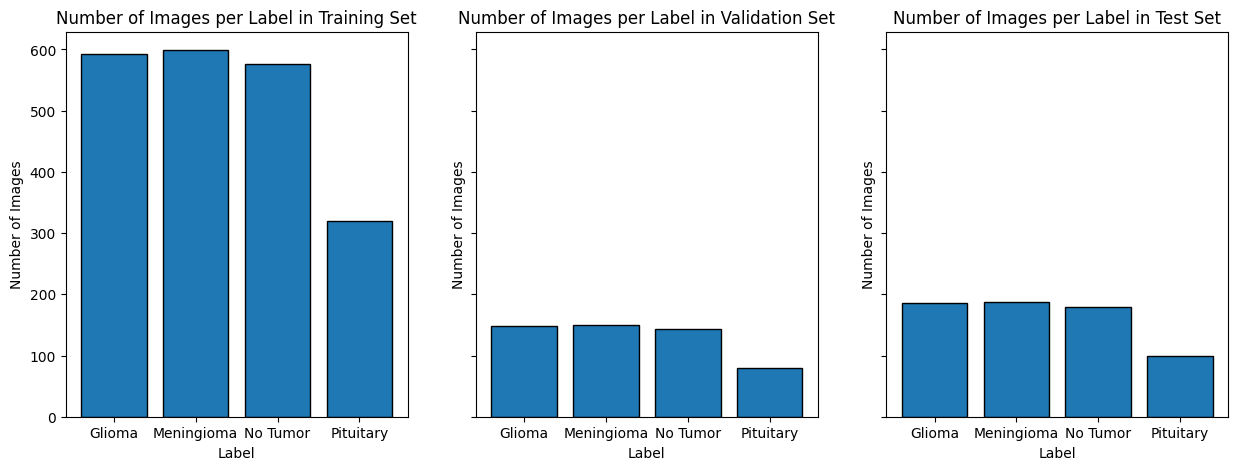

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

unique_labels, label_counts = np.unique(train[:, 1], return_counts=True)
axes[0].bar(unique_labels, label_counts, edgecolor='black')
axes[0].set_xticks(unique_labels)
axes[0].set_xticklabels(['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Number of Images per Label in Training Set')

unique_labels, label_counts = np.unique(val[:, 1], return_counts=True)
axes[1].bar(unique_labels, label_counts, edgecolor='black')
axes[1].set_xticks(unique_labels)
axes[1].set_xticklabels(['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Number of Images')
axes[1].set_title('Number of Images per Label in Validation Set')

unique_labels, label_counts = np.unique(test[:, 1], return_counts=True)
axes[2].bar(unique_labels, label_counts, edgecolor='black')
axes[2].set_xticks(unique_labels)
axes[2].set_xticklabels(['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
axes[2].set_xlabel('Label')
axes[2].set_ylabel('Number of Images')
axes[2].set_title('Number of Images per Label in Test Set')

# Display the plot
plt.show()

### Save the images under train, test and val folders with the respective labels in the folder name

In [5]:
import os
from PIL import Image

def save_images(data, base_folder):
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
    for img_path, label in data:
        label_folder = os.path.join(base_folder, str(label))
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)
        img = Image.open(img_path)
        img.save(os.path.join(label_folder, os.path.basename(img_path)))

if initialized_data!=True:
    # Save the images for each dataset
    save_images(train, 'train')
    save_images(val, 'val')
    save_images(test, 'test')

### Load the images from the folders and perform data augmentation

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    rotation_range=20,           # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,       # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,      # Randomly shift images vertically by 20% of the height
    shear_range=0.2,             # Apply shearing transformations
    zoom_range=0.2,              # Randomly zoom in or out by 20%
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Fill missing pixels after transformations
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    'train',                   
    target_size=(512, 512),     
    batch_size=32,              
    class_mode='categorical'    
)

val_generator = val_datagen.flow_from_directory(
    'val', 
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'test', 
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical'
)



Found 2088 images belonging to 4 classes.
Found 523 images belonging to 4 classes.
Found 653 images belonging to 4 classes.


### Build a CNN model and train it on the images

Epoch 1/200
66/66 [==============================] - ETA: 0s - loss: 1.7346 - accuracy: 0.3027
Epoch 1: val_loss improved from inf to 1.30200, saving model to model.h5


/home/stud/sigurdh/.venv/mcpy310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - 150s 2s/step - loss: 1.7346 - accuracy: 0.3027 - val_loss: 1.3020 - val_accuracy: 0.4245
Epoch 2/200
66/66 [==============================] - ETA: 0s - loss: 1.2870 - accuracy: 0.3788
Epoch 2: val_loss improved from 1.30200 to 1.20573, saving model to model.h5
66/66 [==============================] - 145s 2s/step - loss: 1.2870 - accuracy: 0.3788 - val_loss: 1.2057 - val_accuracy: 0.5621
Epoch 3/200
66/66 [==============================] - ETA: 0s - loss: 1.2359 - accuracy: 0.4080
Epoch 3: val_loss improved from 1.20573 to 1.17782, saving model to model.h5
66/66 [==============================] - 136s 2s/step - loss: 1.2359 - accuracy: 0.4080 - val_loss: 1.1778 - val_accuracy: 0.5335
Epoch 4/200
66/66 [==============================] - ETA: 0s - loss: 1.1753 - accuracy: 0.4559
Epoch 4: val_loss improved from 1.17782 to 1.16486, saving model to model.h5
66/66 [==============================] - 137s 2s/step - loss: 1.1753 - accuracy: 0.4559 - val_

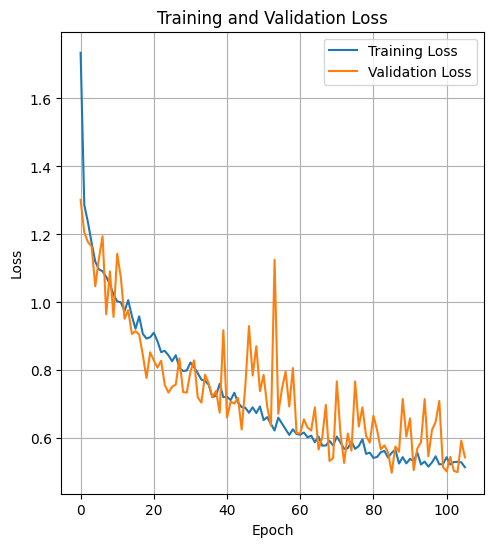

In [12]:
### Build a CNN model and train it on the images
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('model.h5', save_best_only=True, mode='min', monitor='val_loss', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    verbose=1,
    callbacks=[checkpoint, early_stopping]
)
best_epoch = np.argmin(history.history['val_loss']) + 1
print(f'Best epoch: {best_epoch:d}')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

### Predict using the best model

In [ ]:
model.load_weights('model.h5')

threshold = 0.5

predictions = model.predict(test_generator)

21/21 [==============================] - 15s 252ms/step


### Evaluate the model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Calculate metrics
accuracy = np.mean(y_true == y_pred)
precision = np.sum((y_pred == 1) & (y_true == 1)) / np.sum(y_pred == 1)
recall = np.sum((y_pred == 1) & (y_true == 1)) / np.sum(y_true == 1)
f1 = 2 * precision * recall / (precision + recall)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


# Generate a classification report
report = classification_report(y_true, y_pred, target_names=list(class_map.values()))
print(report)


Accuracy: 0.27
Precision: 0.33
Recall: 0.30
F1 Score: 0.31
                  precision    recall  f1-score   support

    glioma_tumor       0.30      0.23      0.26       185
meningioma_tumor       0.33      0.30      0.31       188
 pituitary_tumor       0.27      0.31      0.29       180
        no_tumor       0.16      0.22      0.19       100

        accuracy                           0.27       653
       macro avg       0.26      0.26      0.26       653
    weighted avg       0.28      0.27      0.27       653



### Evaluate the model on the models ability to detect tumor or no tumor

Accuracy: 0.70
Precision: 0.85
Recall: 0.79
F1 Score: 0.82


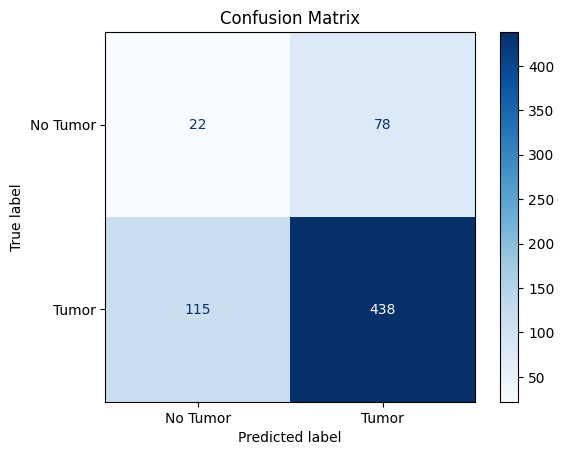

In [89]:
# Calculate metrics for thast groups all the tumor classes together and compares them to the no_tumor class
from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay

y_true_grouped = np.where(y_true == 3, 0, 1)

y_pred_grouped = np.where(y_pred == 3, 0, 1)

# Calculate metrics
accuracy = np.mean(y_true_grouped == y_pred_grouped)
precision = precision_score(y_true_grouped, y_pred_grouped)
recall = recall_score(y_true_grouped, y_pred_grouped)
f1 = f1_score(y_true_grouped, y_pred_grouped)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


# Plot the confusion matrix
cm = confusion_matrix(y_true_grouped, y_pred_grouped)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Tumor', 'Tumor'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Heatmap

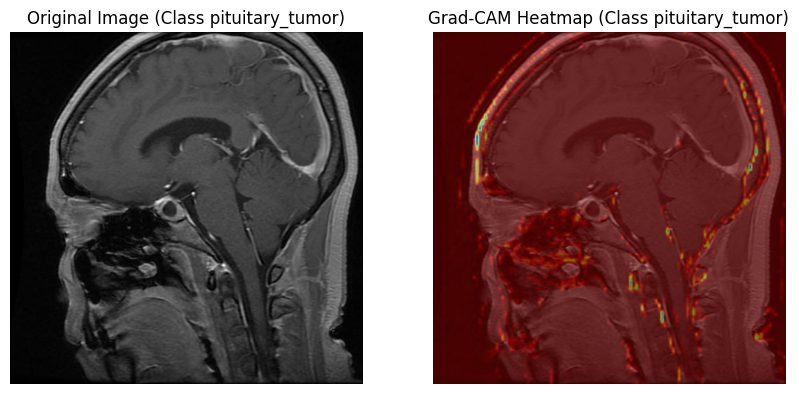

In [61]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_grad_cam(model, image, class_idx, layer_name='conv2d_5'):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        inputs = tf.cast(image, tf.float32)
        (conv_outputs, predictions) = grad_model(inputs)
        loss = predictions[:, class_idx]
    
    grads = tape.gradient(loss, conv_outputs)
    casted_outputs = tf.cast(conv_outputs > 0, "float32")
    casted_grads = tf.cast(grads > 0, "float32")
    guided_grads = casted_outputs * casted_grads * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1, 2))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    return cam[0]

def overlay_heatmap(image, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlayed = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return overlayed

# Get a single batch of images from the test generator
images, labels = next(test_generator)

# Select the first image and its label from the batch
test_image = images[0]  # Shape: (512, 512, 3)
true_label = np.argmax(labels[0])  # Actual label index

# Generate Grad-CAM heatmap for the true label
heatmap = get_grad_cam(model, np.expand_dims(test_image, axis=0), class_idx=true_label)

# Convert the image to uint8 for visualization
test_image_uint8 = (test_image * 255).astype(np.uint8)

# Overlay the heatmap on the original image
overlayed_image = overlay_heatmap(test_image_uint8, heatmap)

# Display the original image and Grad-CAM heatmap
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f"Original Image (Class {class_map[true_label]})")
plt.imshow(test_image_uint8)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM Heatmap (Class {class_map[true_label]})")
plt.imshow(overlayed_image)
plt.axis('off')

plt.show()



In [91]:
import tensorflow as tf
import numpy as np
import cv2

def get_grad_cam(model, image, class_idx, layer_name='conv2d_8'):
    """
    Generates Grad-CAM heatmap for the specified class index.

    Args:
        model: Trained Keras model.
        image: Input image, preprocessed and shaped as (1, H, W, C).
        class_idx: Index of the class for which Grad-CAM is generated.
        layer_name: Name of the convolutional layer to use for Grad-CAM.

    Returns:
        Heatmap (H, W) as a numpy array.
    """
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        inputs = tf.cast(image, tf.float32)  # Ensure float32 precision
        (conv_outputs, predictions) = grad_model(inputs)
        loss = predictions[:, class_idx]  # Loss for the specific class

    # Calculate gradients of the loss w.r.t. the convolutional outputs
    grads = tape.gradient(loss, conv_outputs)
    # Compute channel-wise mean of gradients
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    # Weighted combination of feature maps
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    # ReLU activation (remove negative values)
    cam = np.maximum(cam, 0)
    # Normalize to [0, 1]
    cam = cam / np.max(cam) if np.max(cam) != 0 else cam
    return cam[0]  # Return the heatmap


In [64]:
def overlay_heatmap(image, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """
    Overlays the Grad-CAM heatmap on the original image.

    Args:
        image: Original image (H, W, 3), uint8 format.
        heatmap: Grad-CAM heatmap (H, W), values in [0, 1].
        alpha: Blending factor for heatmap overlay.
        colormap: OpenCV colormap to apply.

    Returns:
        Overlayed image (H, W, 3), uint8 format.
    """
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlayed = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return overlayed


1/1 [==============================] - 6s 6s/step


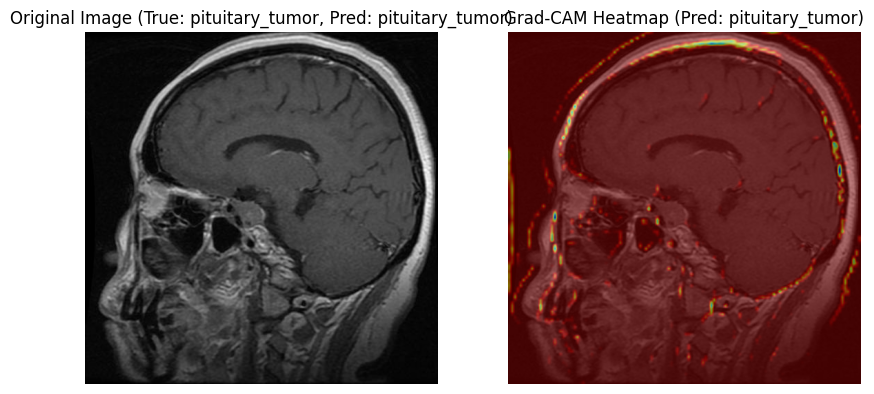

In [118]:
import matplotlib.pyplot as plt

# Get a single batch of images
images, labels = next(test_generator)
test_image = images[0]  # Select the first image
true_label = np.argmax(labels[0])  # True label index
predicted_label = np.argmax(model.predict(np.expand_dims(test_image, axis=0)))

# Generate Grad-CAM for the predicted label
heatmap = get_grad_cam(model, np.expand_dims(test_image, axis=0), class_idx=predicted_label)

# Overlay Grad-CAM on the original image
test_image_uint8 = (test_image * 255).astype(np.uint8)
overlayed_image = overlay_heatmap(test_image_uint8, heatmap)

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f"Original Image (True: {class_map[true_label]}, Pred: {class_map[predicted_label]})")
plt.imshow(test_image_uint8)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM Heatmap (Pred: {class_map[predicted_label]})")
plt.imshow(overlayed_image)
plt.axis('off')

plt.show()
